In [1]:
import pandas as pd
import h3
import folium
from vincenty import vincenty
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Get the dataframe from csv
df = pd.read_csv('witness-data.csv')

In [3]:
#Drop some unused columns
df = df.drop('continent', 1)
df = df.drop('challengee', 1)
df = df.drop('witness', 1)

In [4]:
# Add coordinates for challengee (src) and witness (src)
df['challengee_lat'] = df.apply(lambda row: h3.h3_to_geo(row.challengee_location)[0], axis=1)
df['challengee_long'] = df.apply(lambda row: h3.h3_to_geo(row.challengee_location)[1], axis=1)
df['witness_lat'] = df.apply(lambda row: h3.h3_to_geo(row.witness_location)[0], axis=1)
df['witness_long'] = df.apply(lambda row: h3.h3_to_geo(row.witness_location)[1], axis=1)

In [5]:
# Add distance between challengee and witness
df['distance'] = df.apply(lambda row: vincenty(h3.h3_to_geo(row.challengee_location), h3.h3_to_geo(row.witness_location)), axis = 1)

In [6]:
df.head(5)

,challengee_name,challengee_location,witness_name,witness_location,witness_frequency,witness_snr,witness_rssi,witness_is_valid,challengee_lat,challengee_long,witness_lat,witness_long,distance
0,deep-violet-osprey,8c1eec49851d7ff,nutty-white-turkey,8c1eeeb342465ff,867.700012,-5.8,-116,True,44.511653,25.698337,44.472857,25.721247,4.680407
1,orbiting-sepia-anteater,8c1e130d24191ff,faint-honey-woodpecker,8c1e130d0441dff,867.500000,-16.0,-115,True,45.766654,15.931147,45.787506,15.950885,2.779906
2,immense-shamrock-whale,8c26ed7a5ca21ff,trendy-aquamarine-jay,8c26ed7a18e53ff,905.299988,4.5,-98,True,36.123365,-94.157137,36.099009,-94.146825,2.857641
3,immense-shamrock-whale,8c26ed7a5ca21ff,passive-pineapple-tortoise,8c26ed7a531abff,905.299988,-8.5,-112,True,36.123365,-94.157137,36.110477,-94.142933,1.918389
4,immense-shamrock-whale,8c26ed7a5ca21ff,upbeat-blue-panda,8c26ed7a55293ff,905.299988,7.2,-97,True,36.123365,-94.157137,36.118806,-94.155901,0.517907


In [7]:
m = 10000 # nr. of samples
iVec = rnd.sample(range(0,len(df)),m) # indexs
#print(iVec)

In [8]:
### Get as lists
RSSI = list(df.witness_rssi[iVec].astype(float)) #.astype(float)
#print(RSSI)
SNR = (df.witness_snr[iVec].astype(float))
SNR[SNR == np.inf] = 100
SNR = list(SNR)
#print(SNR)
Dist = df.distance[iVec].astype(float)
Dist[Dist>50] = Dist/1000
Dist[Dist == 0] = 0.01
Dist = list(Dist) 
#print(Dist)

In [9]:
##### Features original + new
#Dist
#RSSI
#SNR
logD = -np.log10(Dist)
logDC = -np.log10([x+3 for x in Dist])
eSNR = np.exp(SNR)
eRSSI = np.exp(RSSI)
invDist = np.reciprocal(Dist)
invSqrtD = np.reciprocal(np.sqrt(Dist))
#invSNR = np.reciprocal(SNR)  # Nope leads to infinity
#invRSSI = np.reciprocal(RSSI) # Nope leads to infinity
invESNR = np.reciprocal(eSNR)
invERSSI = np.reciprocal(eRSSI)
eDist = np.reciprocal(np.exp(Dist))
#print(SNR)
#print(np.min(Dist))

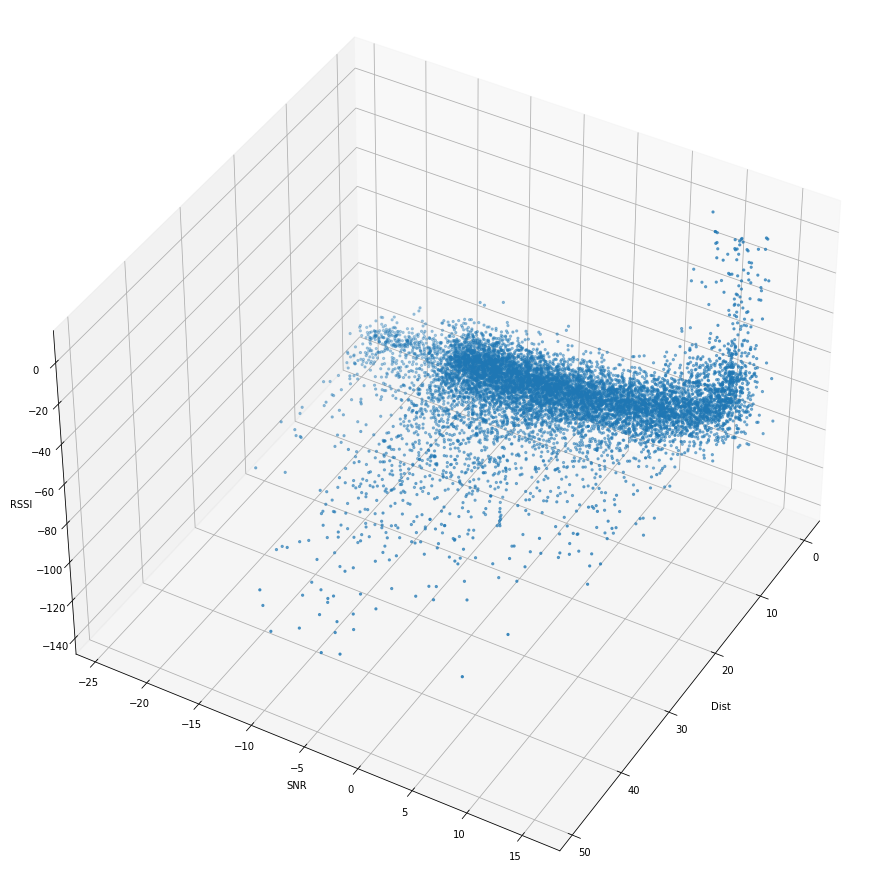

In [33]:
####### Visualize
# fig = plt.figure()
fig = plt.figure(figsize= (16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Dist,SNR,RSSI,marker='.')
ax.elev = 40
ax.azim = 30
ax.set_xlabel('Dist')
ax.set_ylabel('SNR')
ax.set_zlabel('RSSI')
plt.show()

In [11]:
####### Create Feature Vector
X_lol = [Dist, RSSI, SNR, logD, logDC, eSNR, eRSSI, invDist, invSqrtD,  invESNR, invERSSI, eDist]
X = np.array(X_lol)
mu = np.mean(X, axis=1)  
nMax = np.max(X, axis=1)
nMin = np.min(X, axis = 1)
#print(nMin)
scale = np.reciprocal(np.subtract(nMax,nMin))
#print(len(mu),type(mu[0]))

In [12]:
####### Prepare for Corvariance Matrix
ErrX = X
#print(mu)
muMat = np.repeat(mu,m,axis=0)
muMat = np.reshape(muMat, (len(X),m) )
#print(len(muMat), len(muMat[0]))
sclMat = np.repeat(scale,m,axis=0)
sclMat = np.reshape(sclMat, (len(X),m) )
ErrX = X - muMat  # Feature Dispersion Vector
ErrX = np.multiply(ErrX,sclMat)
ErrX = np.array(ErrX)
ErrXT = np.transpose(ErrX) #
#print(len(ErrX), len(ErrX[0]))
#print(len(ErrXT), len(ErrXT[0]))
#print(ErrXT[0])

In [13]:
####### Create Coravariance Matrix
COVAC = np.matmul(ErrX,ErrXT)
#print(len(COVAC),len(COVAC[0]), type(COVAC))
#print(COVAC)
invCOVAC = np.linalg.inv(COVAC)
detCOVAC = np.linalg.det(COVAC)
#print(detCOVAC)
#print(np.matmul(np.matmul(ErrXT[0],invCOVAC),np.transpose(ErrXT[0])))

In [18]:
####### Calc Probabilities
n = len(X)
m = len(X[0])
k1 = np.power(2*np.pi, n/2)
k2 = np.power(detCOVAC, 1/2)
t1 = -np.matmul(np.matmul(ErrXT,invCOVAC),ErrX) / 2
prob = []
for idx in range(0,m):
    t0 = np.matmul(ErrXT[idx],invCOVAC)
    t1 = -np.matmul(t0,np.transpose(ErrXT[idx]))/2
    prob.append(np.exp(t1)) #/k2)
#print(np.min(prob))
#print(type(prob))
#print(len(prob))
#print(t1)

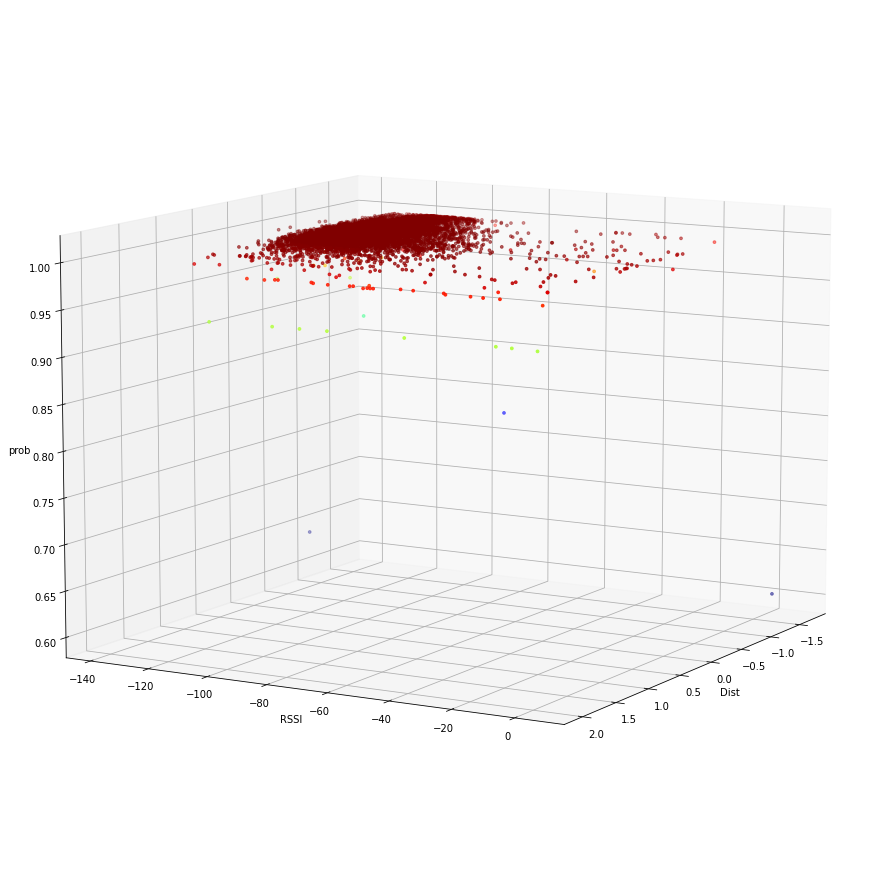

In [32]:
###### Visualize Probabilities
import matplotlib.cm as cm
import itertools
fig = plt.figure(figsize= (16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(logD,RSSI,prob,marker='.', c=np.reciprocal(np.power(prob,-10)), s= 30 , cmap = 'jet')
ax.elev = 10
ax.azim = 30
ax.set_xlabel('Dist')
ax.set_ylabel('RSSI')
ax.set_zlabel('prob')
plt.show()

Text(0, 0.5, 'Number of Transactions')

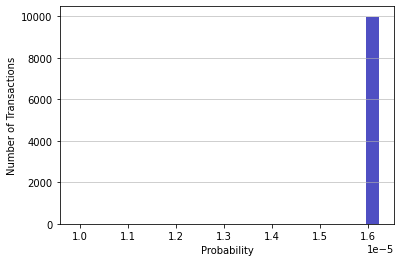

In [16]:
###### How many are Anomalous
first_edge, last_edge = np.max(prob) , np.min(prob)
bins = np.linspace(start=first_edge, stop=last_edge, num=20, endpoint=True)
hist, bins = np.histogram(prob, range = (0,1), bins = 20)
#print(hist)
#print(type(bins))
fig = plt.figure()
n, bins, patches = plt.hist(x=prob, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Probability')
plt.ylabel('Number of Transactions')